In [199]:
import torch
import gpytorch
import numpy as np

import sys
import os
sys.path.append(os.path.abspath('..'))

from src.plotting import plot_gp, plot_train_test_split
from src.data_loader import PVDataGenerator
from src import data_loader as dl
from src.models import MultitaskGPModel
from src.kernel import generate_quasi_periodic


In [200]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)

num_latent = 8

==> Loading data
==> Loaded data in: 0 m : 7 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



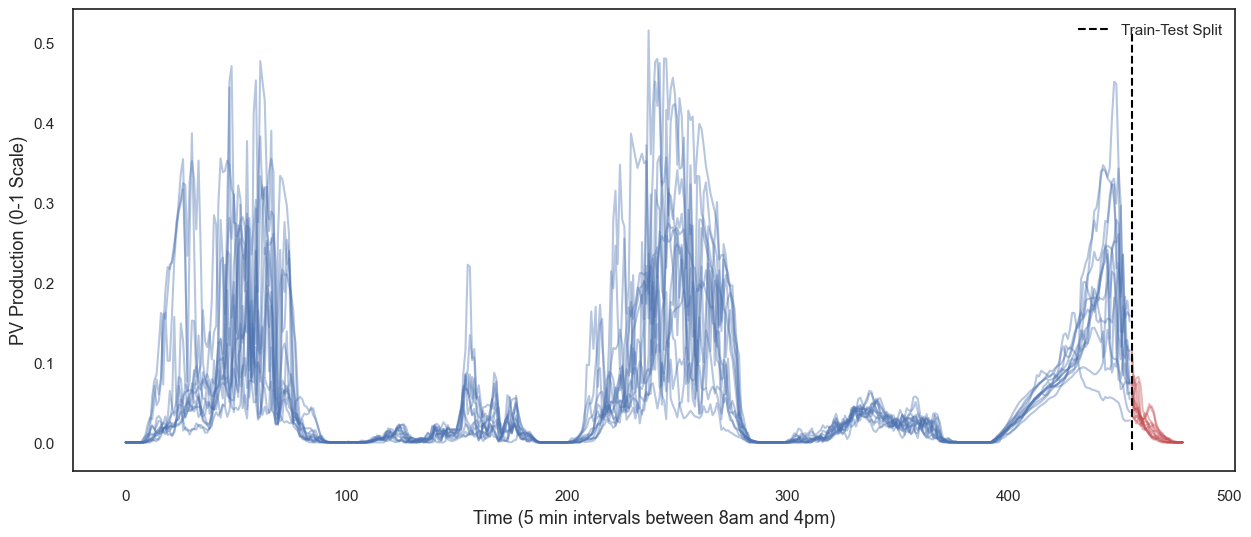

In [201]:
loader = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

X, y = loader.get_time_series()

x_train, y_train, x_test, y_test = dl.train_test_split(X, y, n_hours=N_HOURS_PRED)
plot_train_test_split(y_train, y_test)

In [202]:
from src.beta_likelihood import BetaLikelihood_MeanParametrization
from gpytorch.distributions import base_distributions
from gpytorch.priors import Prior
from gpytorch.constraints import Positive, Interval
from typing import Optional

class MultitaskBetaLikelihood(BetaLikelihood_MeanParametrization):
    """ 
    A multitask BetaLikelihood that supports multitask GP regression.
    """
    def __init__(
        self,
        n_tasks: int,
        scale = 15,
        batch_shape: torch.Size = torch.Size([]),
        scale_prior: Optional[Prior] = None,
        scale_constraint: Optional[Interval] = None,
    ) -> None:
        super().__init__(scale)

        if scale_constraint is None:
            scale_constraint = Positive()

        self.raw_scale = torch.nn.Parameter(torch.ones(*batch_shape, 1, n_tasks))
        if scale_prior is not None:
            self.register_prior("scale_prior", scale_prior, lambda m: m.scale, lambda m, v: m._set_scale(v))

        self.register_constraint("raw_scale", scale_constraint)
    
    def forward(self, function_samples, *args, **kwargs):
        mixture = torch.distributions.Normal(0, 1).cdf(function_samples)
        eps = 1e-9
        
        alpha = mixture * self.scale + eps
        beta = self.scale - alpha + eps

        # corrects the alpha and beta parameters if the mixture is close to the bounds
        self.alpha = torch.where((mixture > self.lower_bound) | (mixture < self.upper_bound), self.correcting_scale * alpha, alpha)
        self.beta = torch.where((mixture > self.lower_bound) | (mixture < self.upper_bound), self.correcting_scale * beta, beta)

        return base_distributions.Beta(concentration1=self.alpha, concentration0=self.beta)


    def expected_log_prob(self, observations, function_dist, *args, **kwargs):
        ret = super().expected_log_prob(observations, function_dist, *args, **kwargs)
        
        num_event_dim = len(function_dist.event_shape)
        
        if num_event_dim > 1:  # Do appropriate summation for multitask likelihood
            ret = ret.sum(list(range(-1, -num_event_dim, -1)))
        return ret
    

In [218]:
beta_likelihood = MultitaskBetaLikelihood(n_tasks=y_train.size(-1))
gaussian_likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y_train.size(-1))


model = MultitaskGPModel(x_train=x_train,
                         y_train=y_train,
                         likelihood=gaussian_likelihood,
                         mean_module=gpytorch.means.ZeroMean(batch_shape=torch.Size([num_latent])),
                         covar_module=generate_quasi_periodic(num_latents=num_latent),
                         num_latents=num_latent,
                         jitter=1e-3)

In [219]:
model.fit(n_iter=1000, lr=0.1, verbose=True)

Iter 100/1000 - Loss: -12.352882385253906
Iter 200/1000 - Loss: -21.4702091217041
Iter 300/1000 - Loss: -22.170570373535156
Iter 400/1000 - Loss: -22.673715591430664
Iter 500/1000 - Loss: -23.20482063293457
Iter 600/1000 - Loss: -23.31170082092285
Iter 700/1000 - Loss: -23.15766716003418
Iter 800/1000 - Loss: -23.160673141479492
Iter 900/1000 - Loss: -23.261507034301758
Iter 1000/1000 - Loss: -23.302640914916992


In [220]:
with torch.no_grad():
    preds_train, lower_train, upper_train = model.predict(model.likelihood, x_train)
    preds_test, lower_test, upper_test = model.predict(model.likelihood, x_test)

In [221]:
preds_test.shape, y_test.shape, x_test.shape

(torch.Size([24, 13]), torch.Size([24, 13]), torch.Size([24, 2]))

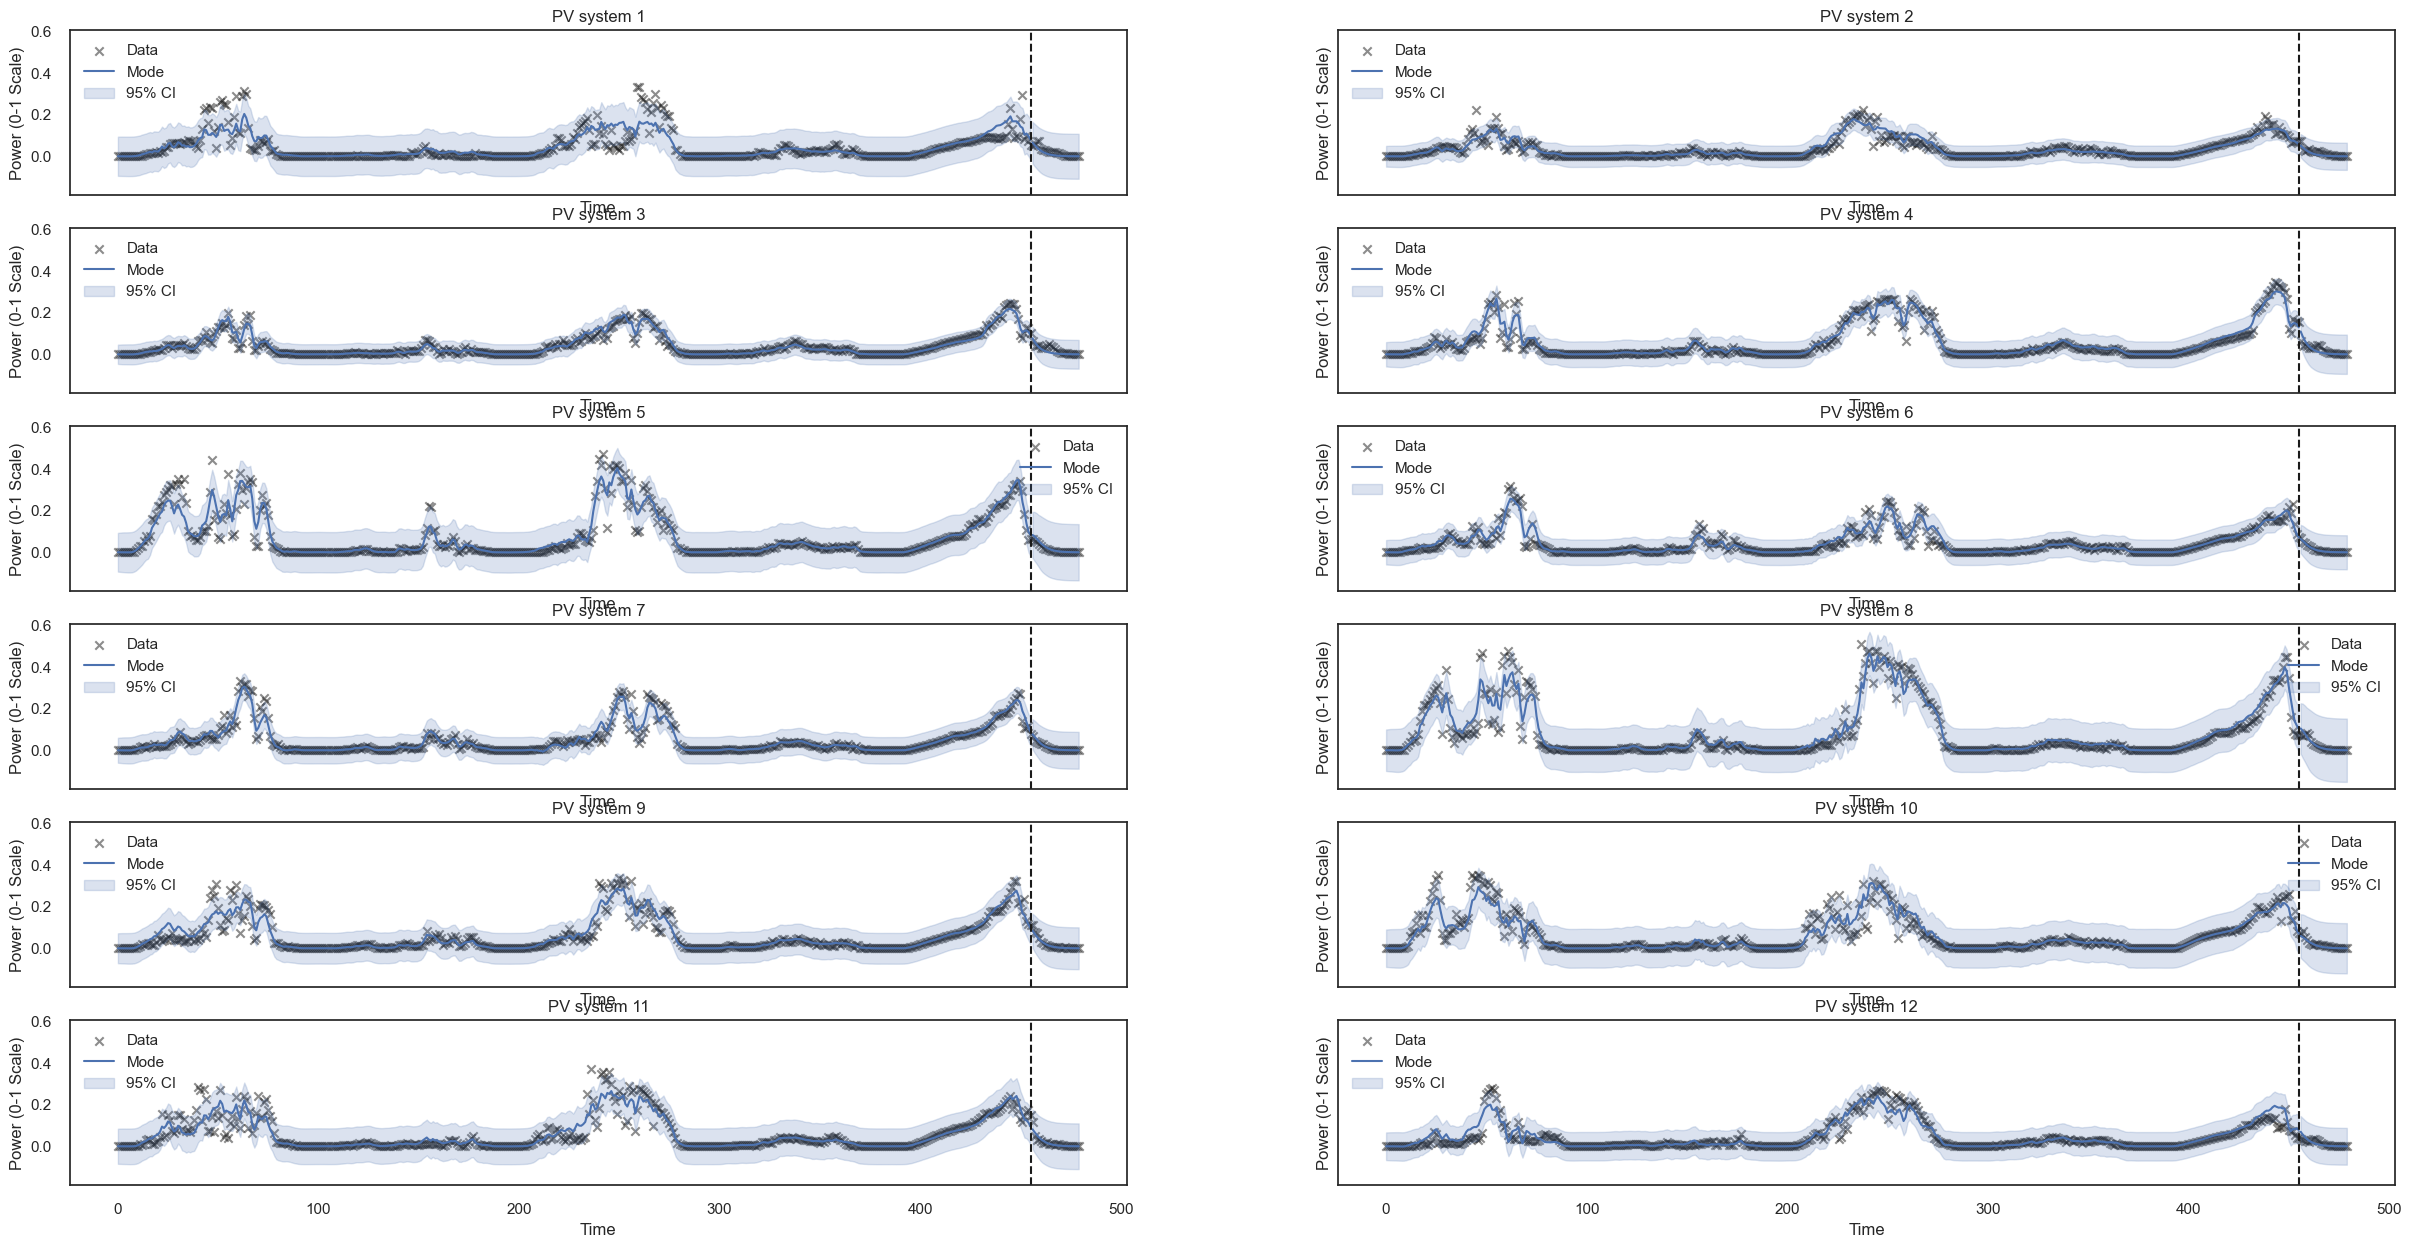

In [222]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(y.size(-1)//2, 2, figsize=(30, 15), sharex=True, sharey=True)

ax = ax.flatten()

for i in range(y.size(-1)-1):
    ax[i].scatter(x_train[:,0], y_train[:, i], marker='x', color='k', alpha=0.5)
    ax[i].scatter(x_test[:,0], y_test[:, i] ,marker='x', color='k', alpha=0.5, label='Data')

    ax[i].plot(x_train[:,0], preds_train[:, i], color='C0', label='Mode')
    ax[i].fill_between(x_train[:,0], lower_train[:, i], upper_train[:, i], color='C0', alpha=0.2, label='95% CI')

    ax[i].plot(x_test[:,0], preds_test[:, i], color='C0')
    ax[i].fill_between(x_test[:,0], lower_test[:, i], upper_test[:, i], color='C0', alpha=0.2)

    ax[i].axvline(x_train[:,0][-1], color='k', linestyle='--')

    ax[i].set_ylabel('Power (0-1 Scale)')
    ax[i].set_xlabel('Time')
    ax[i].set_title(f'PV system {i+1}')
    ax[i].legend()